In [13]:
import pandas as pd
from datasets import load_dataset, DatasetDict, Dataset
import matplotlib.pyplot as plt

In [14]:
competition_math_dict = load_dataset("jeggers/competition_math", "original")
test_dataset = competition_math_dict["test"]
test_dataset_df = pd.DataFrame(test_dataset)
test_dataset_df["row_index"] = test_dataset_df.index

In [15]:
def format_llema_inference_competition_math():
    file_path = "llemma_competition_math_extracted_answers_2.txt"
    with open(file_path, "r") as file:
        data = [eval(line.strip()) for line in file]
    df = pd.DataFrame(data)
    llema_test_dataset= df.merge(test_dataset_df, left_on='Iteration', right_on='row_index')
    llema_test_dataset["level:type"] = llema_test_dataset["level"] + ": " + llema_test_dataset["type"]

    llema_test_dataset["llema_is_correct"] =  (llema_test_dataset["Final Solution"] == llema_test_dataset["extracted_solution"])

    llema_3_results = llema_test_dataset[["row_index", "level", "type", "llema_is_correct"]]
    return llema_3_results

## TODO : Add mistral


def format_llama_inference_competition_math():
    df = pd.read_csv("inference_llama3_competition_math.csv")
    llama3_test_dataset= df.merge(test_dataset_df, left_on='row_index', right_on='row_index')
    llama3_test_dataset["llama3_is_correct"] = (llama3_test_dataset["Run_1"] == llama3_test_dataset["extracted_solution"])
    llama3_test_dataset["level:type"] = llama3_test_dataset["level"] + ": " + llama3_test_dataset["type"]

    llama3_results = llama3_test_dataset[["row_index", "level", "type", "llama3_is_correct"]]
    return llama3_results

def format_qwen_inference_competition_math():
    file_path = "inference_QWEN_competition_math.csv"
    df = pd.read_csv(file_path)

    qwen_test_dataset= df.merge(test_dataset_df, left_on='row_index', right_on='row_index')
    qwen_test_dataset["qwen_is_correct"] = (qwen_test_dataset["Run_1"] == qwen_test_dataset["extracted_solution"])
    qwen_test_dataset["level:type"] = qwen_test_dataset["level"] + ": " + qwen_test_dataset["type"]

    qwen_results = qwen_test_dataset[["row_index", "level", "type", "level:type", "qwen_is_correct"]]
    return qwen_results

In [16]:
llama3_results = format_llama_inference_competition_math()
llema_results = format_llema_inference_competition_math()
qwen_results = format_qwen_inference_competition_math()

In [17]:
all_results = (llama3_results.merge(llema_results)).merge(qwen_results)
all_results["all_correct"] = ((all_results["llama3_is_correct"] == all_results["llema_is_correct"]) == all_results["qwen_is_correct"])
all_results

,row_index,level,type,llama3_is_correct,llema_is_correct,level:type,qwen_is_correct,all_correct
0,0,Level 3,Algebra,True,False,Level 3: Algebra,False,True
1,1,Level 1,Algebra,True,True,Level 1: Algebra,True,True
2,2,Level 4,Algebra,False,False,Level 4: Algebra,True,True
3,3,Level 5,Algebra,True,False,Level 5: Algebra,False,True
4,4,Level 1,Algebra,False,False,Level 1: Algebra,True,True
...,...,...,...,...,...,...,...,...
4995,4956,Level 2,Precalculus,False,False,Level 2: Precalculus,False,False
4996,4957,Level 4,Precalculus,True,False,Level 4: Precalculus,False,True
4997,4958,Level 4,Precalculus,False,False,Level 4: Precalculus,False,False
4998,4959,Level 5,Precalculus,False,False,Level 5: Precalculus,True,True


In [18]:
ensemble_model_all_correct = pd.DataFrame( all_results['all_correct'].value_counts() )
ensemble_model_all_correct

,count
all_correct,
False,3370
True,1630


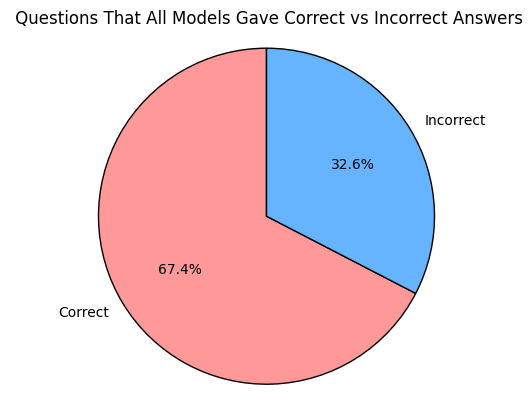

In [19]:
labels = ['Correct', 'Incorrect']
sizes = [ ensemble_model_all_correct['count'].iloc[0],ensemble_model_all_correct['count'].iloc[1]]
colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.axis('equal')
plt.title(' Questions That All Models Gave Correct vs Incorrect Answers')

plt.show()

In [39]:
test_dataset_df["Level:Type"] = test_dataset_df["level"] + ": " + test_dataset_df["type"]
percent_each_leveltype = pd.DataFrame(test_dataset_df["Level:Type"].value_counts())
percent_each_leveltype['count'] = round((percent_each_leveltype['count'] / percent_each_leveltype['count'].sum()) * 100, 1)
percent_each_leveltype['count'] = percent_each_leveltype['count'].astype(str)
percent_each_leveltype['count'] = percent_each_leveltype['count'] + "%"

In [46]:
level_types = all_results['level:type'].unique()

all_level_types = []
questions_right = []
questions_wrong = []

percent_questions_right_total = []
percent_questions_wrong_total = []

percent_questions_right_total_raw = []

for cat in level_types:
    right_row_indices_of_questions = all_results[ ((all_results['level:type'] == cat) & (all_results["all_correct"] == True)) ]["row_index"]
    right_string_row_idxquestions = ", ".join(map(str, right_row_indices_of_questions))

    wrong_row_indices_of_questions = all_results[ ((all_results['level:type'] == cat) & (all_results["all_correct"] == False)) ]["row_index"]
    wrong_string_row_idxquestions = ", ".join(map(str, wrong_row_indices_of_questions))
    
    all_level_types.append(cat)

    questions_right.append(right_string_row_idxquestions)
    questions_wrong.append(wrong_string_row_idxquestions)

    percent_right = (len(right_row_indices_of_questions)) / (len(right_row_indices_of_questions) + len(wrong_row_indices_of_questions)) 
    percent_wrong = (len(wrong_row_indices_of_questions)) / (len(right_row_indices_of_questions) + len(wrong_row_indices_of_questions)) 


    percent_questions_right_total.append( str(round(percent_right*100)) +"%")
    percent_questions_wrong_total.append( str(round (percent_wrong*100)) + "%" )

    percent_questions_right_total_raw.append(percent_right)


individal_question_breakdown = pd.DataFrame(list(zip(all_level_types, questions_right, percent_questions_right_total, percent_questions_right_total_raw, questions_wrong, percent_questions_wrong_total)))
individal_question_breakdown.columns = ['Level:Type', 'Question #s Correct by All Models', 'Total Correct', 'Total Correct Raw', 'Question #s Incorrect by All Models',
'Total Incorrect']
individal_question_breakdown = individal_question_breakdown.merge(percent_each_leveltype, left_on="Level:Type", right_on="Level:Type")
individal_question_breakdown = individal_question_breakdown.sort_values(by=['Total Correct Raw'], ascending=False)
individal_question_breakdown.drop(columns=["Total Correct Raw"])


,Level:Type,Question #s Correct by All Models,Total Correct,Question #s Incorrect by All Models,Total Incorrect,count
23,Level 1: Number Theory,"3051, 3054, 3103, 3150, 3187, 3190, 3211, 3240...",67%,"3140, 3245, 3263, 3282, 3287, 3340, 3383, 3423...",33%,0.6%
28,Level 1: Prealgebra,"3594, 3622, 3634, 3652, 3674, 3693, 3708, 3709...",60%,"3591, 3596, 3606, 3607, 3626, 3651, 3653, 3661...",40%,1.7%
1,Level 1: Algebra,"1, 4, 64, 70, 83, 100, 105, 112, 118, 132, 149...",56%,"13, 19, 24, 65, 84, 102, 126, 154, 199, 207, 2...",44%,2.7%
4,Level 2: Algebra,"5, 12, 42, 44, 72, 79, 101, 103, 115, 127, 140...",54%,"16, 22, 41, 67, 76, 82, 86, 94, 96, 110, 120, ...",46%,4.0%
26,Level 2: Prealgebra,"3602, 3619, 3630, 3646, 3665, 3672, 3682, 3685...",49%,"3584, 3597, 3605, 3616, 3617, 3636, 3641, 3647...",51%,3.5%
34,Level 1: Precalculus,"4481, 4484, 4520, 4545, 4590, 4627, 4630, 4654...",48%,"4488, 4512, 4557, 4560, 4572, 4573, 4585, 4600...",52%,1.1%
19,Level 1: Intermediate Algebra,"2157, 2245, 2289, 2337, 2348, 2371, 2506, 2590...",48%,"2172, 2186, 2206, 2244, 2258, 2268, 2411, 2473...",52%,1.0%
24,Level 3: Number Theory,"3059, 3074, 3088, 3101, 3108, 3117, 3134, 3138...",48%,"3058, 3065, 3068, 3076, 3077, 3091, 3092, 3094...",52%,2.4%
0,Level 3: Algebra,"0, 18, 23, 31, 53, 58, 60, 71, 73, 74, 87, 88,...",47%,"14, 17, 30, 35, 45, 47, 49, 52, 55, 59, 90, 10...",53%,5.2%
20,Level 2: Number Theory,"3045, 3060, 3082, 3124, 3162, 3188, 3198, 3206...",47%,"3043, 3049, 3098, 3115, 3192, 3215, 3221, 3230...",53%,1.8%


In [21]:
categories = all_results['level'].unique()

all_categories = []
percents_correct = []
percents_incorrect = []

for category in categories:
    category_results = pd.DataFrame( all_results[ all_results['level'] == category]['all_correct'].value_counts() )
    num_correct = category_results['count'].iloc[0]
    num_incorrect = category_results['count'].iloc[1]
    percent_correct = num_correct / (num_correct + num_incorrect)
    percent_incorrect = num_incorrect / (num_correct + num_incorrect)

    all_categories.append(category)
    percents_correct.append(percent_correct)
    percents_incorrect.append(percent_incorrect)

results_by_category = pd.DataFrame(list(zip(all_categories, percents_correct, percents_incorrect)))
results_by_category.columns = ['Level', '% Correct', '% Incorrect']
results_by_category = results_by_category.sort_values(by=['Level'])
results_by_category = results_by_category.round(2)
results_by_category

,Level,% Correct,% Incorrect
1,Level 1,0.52,0.48
4,Level 2,0.58,0.42
0,Level 3,0.62,0.38
2,Level 4,0.71,0.29
3,Level 5,0.82,0.18


In [72]:
percent_each_level = pd.DataFrame(test_dataset_df["level"].value_counts())
percent_each_level['count'] = round(percent_each_level['count'] / percent_each_level['count'].sum(), 2)
#percent_each_level['count'] = percent_each_level['count'] + "%"
percent_each_level.columns = ["percent"]
percent_each_level.percent = pd.to_numeric(percent_each_level.percent)

percent_each_level = percent_each_level.sort_values(by=['level'])
percent_each_level

,percent
level,
Level 1,0.09
Level 2,0.18
Level 3,0.23
Level 4,0.24
Level 5,0.26


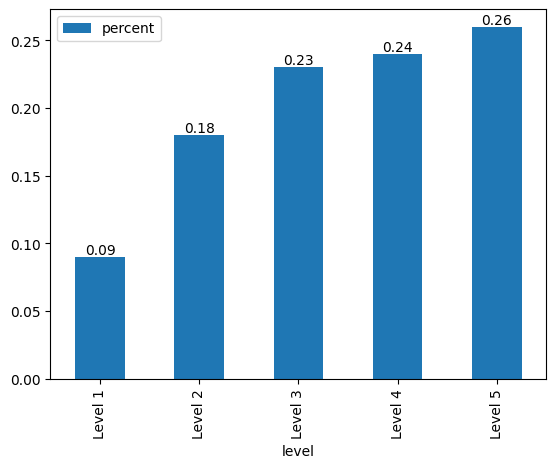

In [73]:
ax =  percent_each_level.plot.bar()

for container in ax.containers:
    ax.bar_label(container)

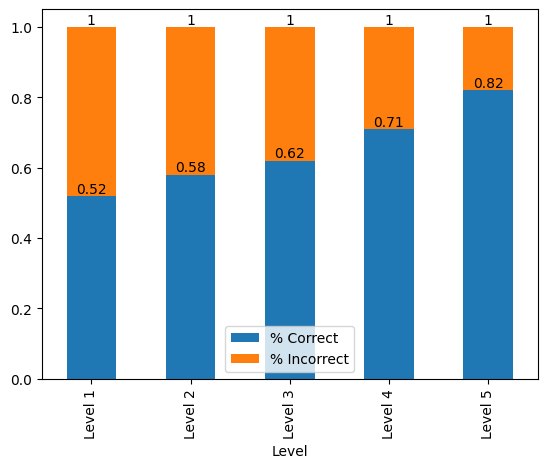

In [22]:
ax = results_by_category.plot.bar(x= 'Level',stacked= True)

for container in ax.containers:
    ax.bar_label(container)

In [23]:
categories = all_results['type'].unique()

all_categories = []
percents_correct = []
percents_incorrect = []

for category in categories:
    category_results = pd.DataFrame( all_results[ all_results['type'] == category]['all_correct'].value_counts() )
    num_correct = category_results['count'].iloc[0]
    num_incorrect = category_results['count'].iloc[1]
    percent_correct = num_correct / (num_correct + num_incorrect)
    percent_incorrect = num_incorrect / (num_correct + num_incorrect)

    all_categories.append(category)
    percents_correct.append(percent_correct)
    percents_incorrect.append(percent_incorrect)

results_by_category = pd.DataFrame(list(zip(all_categories, percents_correct, percents_incorrect)))
results_by_category.columns = ['Type', '% Correct', '% Incorrect']
results_by_category = results_by_category.sort_values(by=['Type'])
results_by_category = results_by_category.round(2)
results_by_category

,Type,% Correct,% Incorrect
0,Algebra,0.55,0.45
1,Counting & Probability,0.72,0.28
2,Geometry,0.80,0.20
3,Intermediate Algebra,0.80,0.20
4,Number Theory,0.61,0.39
5,Prealgebra,0.58,0.42
6,Precalculus,0.78,0.22


In [74]:
percent_each_type = pd.DataFrame(test_dataset_df["type"].value_counts())
percent_each_type['count'] = round(percent_each_type['count'] / percent_each_type['count'].sum(), 2)
percent_each_type.columns = ["percent"]
percent_each_type.percent = pd.to_numeric(percent_each_type.percent)

percent_each_type

,percent
type,
Algebra,0.24
Intermediate Algebra,0.18
Prealgebra,0.17
Precalculus,0.11
Number Theory,0.11
Geometry,0.10
Counting & Probability,0.09


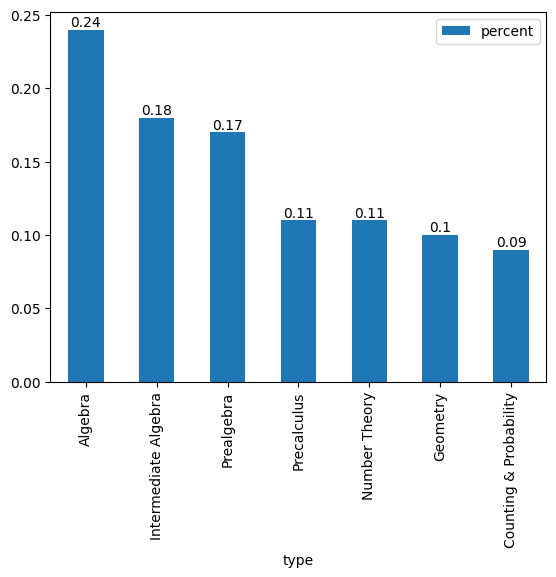

In [75]:
ax =  percent_each_type.plot.bar()

for container in ax.containers:
    ax.bar_label(container)

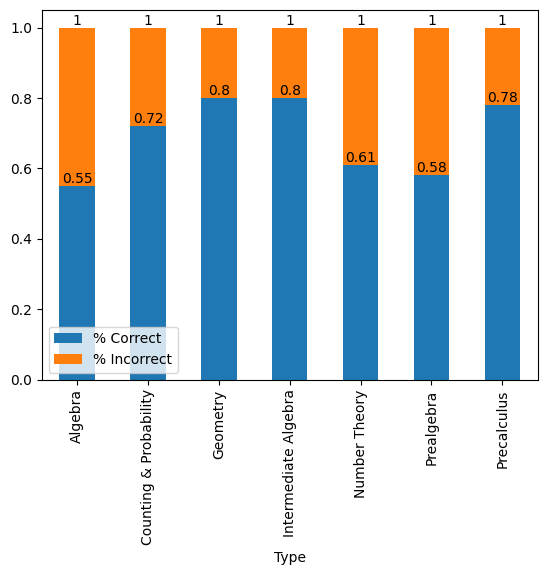

In [24]:
ax = results_by_category.plot.bar(x= 'Type',stacked= True)

for container in ax.containers:
    ax.bar_label(container)
